In [1]:
import netCDF4
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import measure

import xml.etree.ElementTree as ET

import os
import datetime

### Pipeline (.nc climate data to .jpg and .xml)
*Per .nc file, representing one date with 8 timeframes*

1) (8) 1152x768 tri-nary masks

- split_masks()

2) (8\*2) 1152x768 bi-nary masks (Alaska upper left)

- mask_to_contour_coordinates()

3) (8\*2) lists of [[x1, y1], [x2, y2]...] contours (sets of coordinates with area above 50 px)

- contours_to_polygons()

4) (8\*2) lists of [[x1, y1], [x2, y2]...] polygons (sets of coordinates). Much fewer points per polygon than per contour.

___

5) (8) Initialized xml, fields:
- \<filename>data-yyyy-mm-dd-tt-1.jpg\</filename>
- \<folder>tmq\</folder>
- \<session_id>inference\</session_id>
- \<imagesize>\<nrows>768\</nrows>\<ncols>1152\</ncols>\</imagesize>
- \<tc_count>#_of_tc\</tc_count>
- \<ar_count>#_of_ar\</ar_count>
- \<source>\<sourceImage>The MIT-CSAIL database of objects and scenes\</sourceImage>\<sourceAnnotation>LabelMe Webtool\</sourceAnnotation>\</source>

- compile_xml()

6) (8) updated polygon objects, looped into xml
- \<object>\<name>ar#\</name>\<confidence>Medium\</confidence>\<deleted>0\</deleted>\<verified>0\</verified><occluded/><attributes/>\<parts>\<hasparts/>\<ispartof/>\</parts>\<date>dd-Mmm-yyyy hh:mm:ss\</date>\<id>0\</id>\<polygon>\<username>anonymous\</username>\<pt>
- \<x>#\</x>\<y>#\</y> ((0, 0) at top left over Alaska)
- \</pt>\</polygon>\</object>

- compile_xml()

7) (8) save xml string to files, one per time slice

- write_xml()

In [6]:
def split_masks(mask):
    ar_mask = np.copy(mask)
    tc_mask = np.copy(mask)
    ar_mask[ar_mask == 1] = 0
    tc_mask[tc_mask == 2] = 0
    return (ar_mask, tc_mask)

def roll_180(mask):
    return np.roll(mask, 1152//2)

def mask_to_contour_coordinates(mask, area_cut=50):
    #cut pixels on the meridian edge of the map to avoid open contours
    mask[:, 0] = 0
    mask[:, -1] = 0
    
    contours = measure.find_contours(mask, 0)
    include = np.array([True for _ in contours])
    for i, c in enumerate(contours):
        area = measure.moments_coords(c,order=1)[0, 0]
        if area < area_cut:
            include[i] = False
    return [contours[i]  for i in range(0,len(include)) if include[i]]

def contours_to_polygons(contour_coords, tolerance=8):
    return np.array([measure.approximate_polygon(c, tolerance) for c in contour_coords])

In [3]:
def compile_xml(filename, ar_polygon_lists, tc_polygon_lists):
    date_chunks = filename.split(".")[-2].split("-")[1:4]
    
    eight_xml_strings = []
    for i, ar_polygon_list in enumerate(ar_polygon_lists):
        annotation = ET.Element('annotation')

        filename_ = ET.SubElement(annotation, 'filename')
        filename_.text = 'data-'+date_chunks[0]+'-'+date_chunks[1]+'-'+date_chunks[2]+'-0'+str(i+1)+'-1.jpg'
        folder = ET.SubElement(annotation, 'folder')
        folder.text = 'tmq'
        session_id = ET.SubElement(annotation, 'session_id')
        session_id.text = '155'
        imagesize = ET.SubElement(annotation, 'imagesize')
        
        nrows = ET.SubElement(imagesize, 'nrows')
        nrows.text = '768'
        ncols = ET.SubElement(imagesize, 'ncols')
        ncols.text = '1152'
        
        tc_count = ET.SubElement(annotation, 'tc_count')
        tc_count.text = str(len(tc_polygon_lists[i]))
        ar_count = ET.SubElement(annotation, 'ar_count')
        ar_count.text = str(len(ar_polygon_list))
        source = ET.SubElement(annotation, 'source')

        sourceimage = ET.SubElement(source, 'sourceimage')
        sourceimage.text = 'The MIT-CSAIL database of objects and scenes'
        sourceannotation = ET.SubElement(source, 'sourceannotation')
        sourceannotation.text = 'LabelMe Webtool'
        
        for j, poly in enumerate(ar_polygon_list):
            object_ = ET.SubElement(annotation, 'object')
            
            name = ET.SubElement(object_, 'name')
            name.text = "ar"+str(j)
            confidence = ET.SubElement(object_, 'confidence')
            confidence.text = 'Medium'
            deleted = ET.SubElement(object_, 'deleted')
            deleted.text = "0"
            occluded = ET.SubElement(object_, 'occluded')
            occluded.text = "0"
            attributes = ET.SubElement(object_, 'attributes')
            parts = ET.SubElement(object_, 'parts')
            
            hasparts = ET.SubElement(parts, 'hasparts')
            ispartof = ET.SubElement(parts, 'ispartof')
            
            date = ET.SubElement(object_, 'date')
            date.text = "08-Apr-2020 12:00:00"
            id_ = ET.SubElement(object_, 'id')
            id_.text = str(j) #+ len(ar_polygon_list) for tc
            polygon = ET.SubElement(object_, 'polygon')

            username = ET.SubElement(polygon, 'username')
            username.text = "inference_generated"
            for point in poly:
                pt = ET.SubElement(polygon, 'pt')
                
                x = ET.SubElement(pt, 'x')
                #TRANSPOSE
                x.text = str(int(point[1]))
                y = ET.SubElement(pt, 'y')
                y.text = str(int(point[0]))
            
            
        for j, poly in enumerate(tc_polygon_lists[i]):
            object_ = ET.SubElement(annotation, 'object')
            
            name = ET.SubElement(object_, 'name')
            name.text = "tc"+str(j)
            confidence = ET.SubElement(object_, 'confidence')
            confidence.text = 'Medium'
            deleted = ET.SubElement(object_, 'deleted')
            deleted.text = "0"
            occluded = ET.SubElement(object_, 'occluded')
            occluded.text = "0"
            attributes = ET.SubElement(object_, 'attributes')
            parts = ET.SubElement(object_, 'parts')
            
            hasparts = ET.SubElement(parts, 'hasparts')
            ispartof = ET.SubElement(parts, 'ispartof')
            
            date = ET.SubElement(object_, 'date')
            date.text = "08-Apr-2020 12:00:00"
            id_ = ET.SubElement(object_, 'id')
            id_.text = str(j+len(ar_polygon_list))
            polygon = ET.SubElement(object_, 'polygon')

            username = ET.SubElement(polygon, 'username')
            username.text = "anonymous"
            for point in poly:
                pt = ET.SubElement(polygon, 'pt')
                
                x = ET.SubElement(pt, 'x')
                #TRANSPOSE
                x.text = str(int(point[1]))
                y = ET.SubElement(pt, 'y')
                y.text = str(int(point[0]))
                
        eight_xml_strings = np.append(eight_xml_strings, ET.tostring(annotation, encoding="unicode"))

    return eight_xml_strings
    
def write_xml(xml_str, rel_path):
    full_path = rel_path + xml_str[22:43] + "xml"
    with open(full_path, 'w') as output_file:
        output_file.write(xml_str)

### Example usage of above funcs

In [5]:
feb_02_masks = netCDF4.Dataset("./segmentation_masks/CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2.1995-02-01-00000.nc")
feb_02_weather = netCDF4.Dataset("./climate_inputs/CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2.1995-02-01-00000.nc")

feb_02_masks

FileNotFoundError: [Errno 2] No such file or directory: b'./segmentation_masks/CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2.2000-02-01-00000.nc'

In [ ]:
weather = np.array(feb_02_weather.variables["TMQ"])
weather = [split_masks(m) for m in weather]
#weather = [(roll_180(m[0]), roll_180(m[1])) for m in weather]

masks = np.array(feb_02_masks.variables["label"])
masks = [split_masks(m) for m in masks]
#masks = [(roll_180(m[0]), roll_180(m[1])) for m in masks] 

plt.figure(figsize=(20, 20))
plt.imshow(weather[0][0])
plt.imshow(masks[0][0], alpha=0.2)

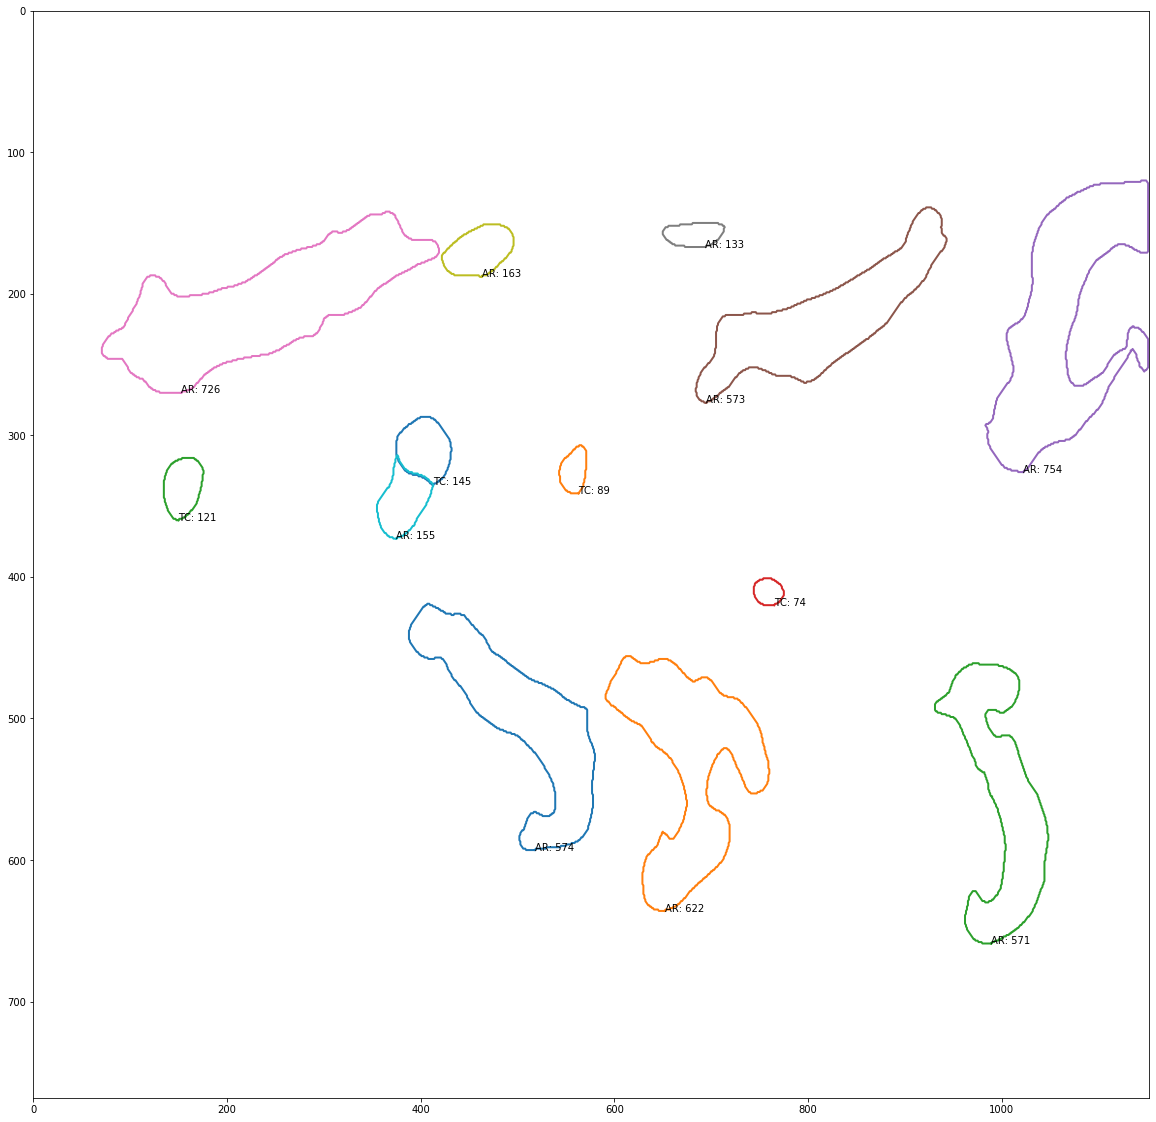

In [13]:
# pure contours
ar_contours = mask_to_contour_coordinates(masks[0][0], 100)
tc_contours = mask_to_contour_coordinates(masks[0][1], 0)

plt.figure(figsize=(20, 20))
for n, contour in enumerate(tc_contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    area = measure.moments_coords(contour,order=1)[0, 0]
    plt.text(contour[0, 1], contour[0, 0], "TC: "+str(int(area)))
    
for n, contour in enumerate(ar_contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    area = measure.moments_coords(contour,order=1)[0, 0]
    plt.text(contour[0, 1], contour[0, 0], "AR: "+str(int(area)))

plt.xlim((0, 1152))
plt.ylim((0, 768))
plt.gca().invert_yaxis()

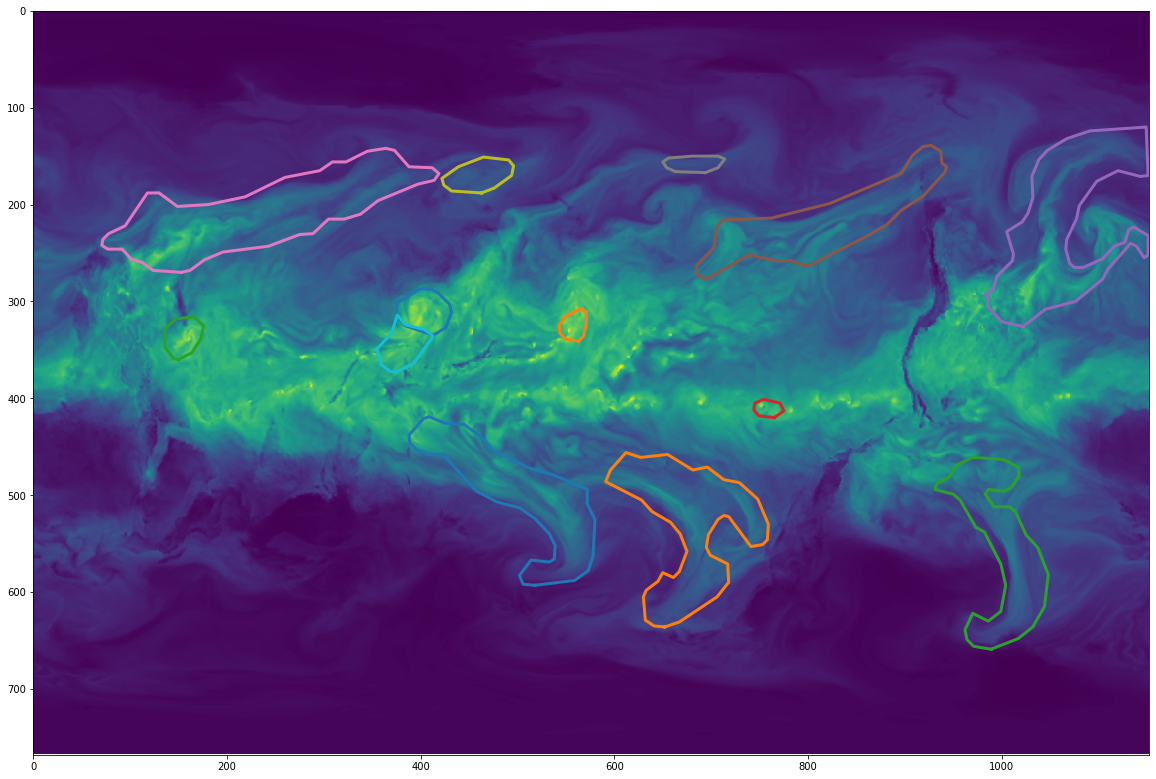

In [14]:
# polygon approximation
ar_poly_contours = contours_to_polygons(ar_contours, tolerance=2)
tc_poly_contours = contours_to_polygons(tc_contours, tolerance=2)

plt.figure(figsize=(20, 20))
for n, polygon in enumerate(tc_poly_contours):
    plt.plot(polygon[:, 1], polygon[:, 0], linewidth=3)
    
for n, polygon in enumerate(ar_poly_contours):
    plt.plot(polygon[:, 1], polygon[:, 0], linewidth=3)

plt.xlim((0, 1152))
plt.ylim((0, 768))
plt.imshow(weather[0][0])
plt.gca().invert_yaxis()

## Mayur Review

In [15]:
# Run on 5 random dates for 5 tollerance values
np.random.seed(155)
rel_path_c = './climate_inputs/'
rel_path_m = "./segmentation_masks/"
tolerances = [2, 4, 6, 9, 12, 15]
five_names = np.random.choice(os.listdir(rel_path_m), 5)

#for fname in five_names:
    mask_data = netCDF4.Dataset(rel_path_m+fname)
    climate_data = netCDF4.Dataset(rel_path_c+fname)
    
    weather = np.array(climate_data.variables["TMQ"])
    weather = [split_masks(m) for m in weather]
    masks = np.array(mask_data.variables["label"])
    masks = [split_masks(m) for m in masks]
    
    ar_contours = mask_to_contour_coordinates(masks[0][0], 100)
    tc_contours = mask_to_contour_coordinates(masks[0][1], 0)
    
    
    fig, axs = plt.subplots(2, 3, figsize=(1152//10, 768//10))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(weather[0][0])
        ax.imshow(masks[0][0], alpha=0.3)
        ax.imshow(masks[0][1], alpha=0.3)
        
        ar_poly_contours = contours_to_polygons(ar_contours, tolerance=tolerances[i])
        tc_poly_contours = contours_to_polygons(tc_contours, tolerance=tolerances[i])
        for n, polygon in enumerate(tc_poly_contours):
            ax.plot(polygon[:, 1], polygon[:, 0], linewidth=2, color='orange')

        for n, polygon in enumerate(ar_poly_contours):
            ax.plot(polygon[:, 1], polygon[:, 0], linewidth=2, color='pink')
    
        ax.set_title("Tolerance: "+str(tolerances[i]), fontsize=150)
        plt.savefig("./review_plots/"+fname[-19:-9]+"_comparison.png")

IndentationError: unexpected indent (<ipython-input-15-693251b82b92>, line 9)

## XML WORK

In [10]:
f_name = "CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2.1995-02-01-00000.nc"
eight_ar = [ar_poly_contours]
eight_tc = [tc_poly_contours]
ret_val = compile_xml(f_name, eight_ar, eight_tc)

In [145]:
write_xml(ret_val[0], "./xml_out/")

## Background image decoding

go from netcdf4 -> jpg

In [2]:
# These have dates in the file name
ivt_tmq_path = "..."

#
psl_path = "..."
#ivt_tmq_names = os.listdir(ivt_tmq_path)
psl_names = os.listdir(psl_path)

FileNotFoundError: [Errno 2] No such file or directory: '...'

In [87]:
import json

json = json.dumps(psl_days_to_name_str)
f = open("psl_days_to_name_str.json","w")
f.write(json)
f.close()

len(psl_days_to_name_str)

7634

## Write images

In [32]:
for f_check in os.listdir(ivt_tmq_path+"2000"):
    data = netCDF4.Dataset(ivt_tmq_path+"2000"+"/"+f_check)

    psl_date = f_check[-19:]
    psl_data = netCDF4.Dataset(psl_path+psl_date)
    print(data)
    break
    date_value = str(psl_data.variables['date'][0].__int__())
    date_str = date_value[0:4]+'-'+date_value[4:6]+'-'+date_value[6:]

    psl_array_eight = psl_data.variables['PSL']
    ivt_array_eight = data.variables['IVT']
    tmq_array_eight = data.variables['IWV']

    for i in range(8):
        left = 'data-'+date_str+'-0'+str(i+1)+'-1.jpg'

        image_array = np.flip(psl_array_eight[i], axis=0)
        mpimg.imsave('./jpg_out/container_a/psl/'+left, image_array)

        image_array = np.flip(ivt_array_eight[i], axis=0)
        mpimg.imsave('./jpg_out/container_a/ivt/'+left, image_array)

        image_array = np.flip(tmq_array_eight[i], axis=0)
        mpimg.imsave('./jpg_out/container_a/tmq/'+left, image_array)

In [144]:
ivt_written = os.listdir('...')
len(ivt_written)

11681

In [9]:
root = "/global/cfs/projectdirs/ClimateNet/qa_pipeline/colby_scripts/netcdf_to_xml/jpg_out/container_b/vorticity"
for old_name in os.listdir(root):
    #new_name = root+"/"+old_name[5:]
    new_name = root+"/"+old_name[:-5] + '0' + old_name[-5] + '-1.jpg'
    os.rename(root+"/"+old_name, new_name)


In [8]:
weather_list_a = np.sort(os.listdir(".../colby_scripts/netcdf_to_xml/jpg_out/container_a/tmq/"))
weather_list_b = np.sort(os.listdir(".../colby_scripts/netcdf_to_xml/jpg_out/container_b/tmq/"))
weather_list_c = np.sort(os.listdir(".../colby_scripts/netcdf_to_xml/jpg_out/container_c/tmq/"))
weather_list_d = np.sort(os.listdir(".../colby_scripts/netcdf_to_xml/jpg_out/container_d/tmq/"))
#weather_list_a[0]#, weather_list_b[0], weather_list_c[0], weather_list_d[0]

## Write XML

In [16]:
#Split chronologically into 4 contianers
for i in np.arange(0, len(weather_list_a), 8):
    f_name = weather_list_a[i]
    if f_name.count('-') != 5:
        continue
    f_date_str = f_name[5:15]
    target = ".../CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2."+f_date_str+"-00000.nc"
    pass_name = target[-66:]
    
    mask_data = netCDF4.Dataset(target)
    masks = np.array(mask_data.variables["label"])
    masks = [roll_180(split_masks(m)) for m in masks]
    
    ar_contours = [0 for _ in range(8)]
    tc_contours = [0 for _ in range(8)]
    for i, mask_tuple in enumerate(masks):
        ar_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[0]), 100), 2)
        tc_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[1]), 0), 2)
     
    
    
    ret_val = compile_xml(f_name, ar_contours, tc_contours)
    [write_xml(r, "./xml_out/container_a/tmq/") for r in ret_val]
    #plt.figure(figsize=(20, 20))
    #for n, polygon in enumerate(ar_contours[0]):
    #    plt.plot(polygon[:, 1], polygon[:, 0], linewidth=3)
    #plt.gca().invert_yaxis()
    #break

print('done a')

done a


In [17]:
for i in np.arange(0, len(weather_list_b), 8):
    f_name = weather_list_b[i]
    if f_name.count('-') != 5:
        continue
    f_date_str = f_name[5:15]
    target = ".../CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2."+f_date_str+"-00000.nc"
    pass_name = target[-66:]
    
    mask_data = netCDF4.Dataset(target)
    masks = np.array(mask_data.variables["label"])
    masks = [roll_180(split_masks(m)) for m in masks]
    
    ar_contours = [0 for _ in range(8)]
    tc_contours = [0 for _ in range(8)]
    for i, mask_tuple in enumerate(masks):
        ar_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[0]), 100), 2)
        tc_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[1]), 0), 2)
        
    ret_val = compile_xml(f_name, ar_contours, tc_contours)
    [write_xml(r, "./xml_out/container_b/tmq/") for r in ret_val]

print('done b')



done b


In [18]:

for i in np.arange(0, len(weather_list_c), 8):
    f_name = weather_list_c[i]
    if f_name.count('-') != 5:
        continue
    f_date_str = f_name[5:15]
    target = ".../CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2."+f_date_str+"-00000.nc"
    pass_name = target[-66:]
    
    mask_data = netCDF4.Dataset(target)
    masks = np.array(mask_data.variables["label"])
    masks = [roll_180(split_masks(m)) for m in masks]
    
    ar_contours = [0 for _ in range(8)]
    tc_contours = [0 for _ in range(8)]
    for i, mask_tuple in enumerate(masks):
        ar_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[0]), 100), 2)
        tc_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[1]), 0), 2)
        
    ret_val = compile_xml(f_name, ar_contours, tc_contours)
    [write_xml(r, "./xml_out/container_c/tmq/") for r in ret_val]

print('done c')


done c


In [19]:
for i in np.arange(0, len(weather_list_d), 8):
    f_name = weather_list_d[i]
    if f_name.count('-') != 5:
        continue
    f_date_str = f_name[5:15]
    target = ".../CAM5-1-0.25degree_All-Hist_est1_v3_run1.cam.h2."+f_date_str+"-00000.nc"
    pass_name = target[-66:]
    
    mask_data = netCDF4.Dataset(target)
    masks = np.array(mask_data.variables["label"])
    masks = [roll_180(split_masks(m)) for m in masks]
    
    ar_contours = [0 for _ in range(8)]
    tc_contours = [0 for _ in range(8)]
    for i, mask_tuple in enumerate(masks):
        ar_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[0]), 100), 2)
        tc_contours[i] = contours_to_polygons(mask_to_contour_coordinates(np.flipud(mask_tuple[1]), 0), 2)
        
    ret_val = compile_xml(f_name, ar_contours, tc_contours)
    [write_xml(r, "./xml_out/container_d/tmq/") for r in ret_val]

print('done d')

done d


In [ ]:
    if i < len(weather_list)/4:
        ret_val = compile_xml(f_name, ar_contours, tc_contours)
        [write_xml(r, "./xml_out/container_a/") for r in ret_val]
        #os.rename('./jpg_out/ivt/'+f_name, './jpg_out/container_a/ivt/'+f_name)
        #os.rename('./jpg_out/psl/'+f_name, './jpg_out/container_a/psl/'+f_name)
        #os.rename('./jpg_out/tmq/'+f_name, './jpg_out/container_a/tmq/'+f_name)
    elif i < len(weather_list)/4 * 2:
        pass_name = target[-66:]
        ret_val = compile_xml(f_name, ar_contours, tc_contours)
        [write_xml(r, "./xml_out/container_b/") for r in ret_val]
        #os.rename('./jpg_out/ivt/'+f_name, './jpg_out/container_b/ivt/'+f_name)
        #os.rename('./jpg_out/psl/'+f_name, './jpg_out/container_b/psl/'+f_name)
        #os.rename('./jpg_out/tmq/'+f_name, './jpg_out/container_b/tmq/'+f_name)
    elif i < len(weather_list)/4 * 3:
        pass_name = target[-66:]
        ret_val = compile_xml(f_name, ar_contours, tc_contours)
        [write_xml(r, "./xml_out/container_c/") for r in ret_val]
        #os.rename('./jpg_out/ivt/'+f_name, './jpg_out/container_c/ivt/'+f_name)
        #os.rename('./jpg_out/psl/'+f_name, './jpg_out/container_c/psl/'+f_name)
        #os.rename('./jpg_out/tmq/'+f_name, './jpg_out/container_c/tmq/'+f_name)
    else:
        pass_name = target[-66:]
        ret_val = compile_xml(f_name, ar_contours, tc_contours)
        [write_xml(r, "./xml_out/container_d/") for r in ret_val]
        #os.rename('./jpg_out/ivt/'+f_name, './jpg_out/container_d/ivt/'+f_name)
        #os.rename('./jpg_out/psl/'+f_name, './jpg_out/container_d/psl/'+f_name)
        #os.rename('./jpg_out/tmq/'+f_name, './jpg_out/container_d/tmq/'+f_name)

In [8]:
a_names = np.sort(os.listdir('.../colby_scripts/netcdf_to_xml/xml_out/container_d/'))
with open('.../colby_scripts/netcdf_to_xml/xml_out/xmls_text_bodge/container_d/xmls.txt', 'w') as f:
    for item in a_names:
        f.write("%s\n" % item)

### Color Bar

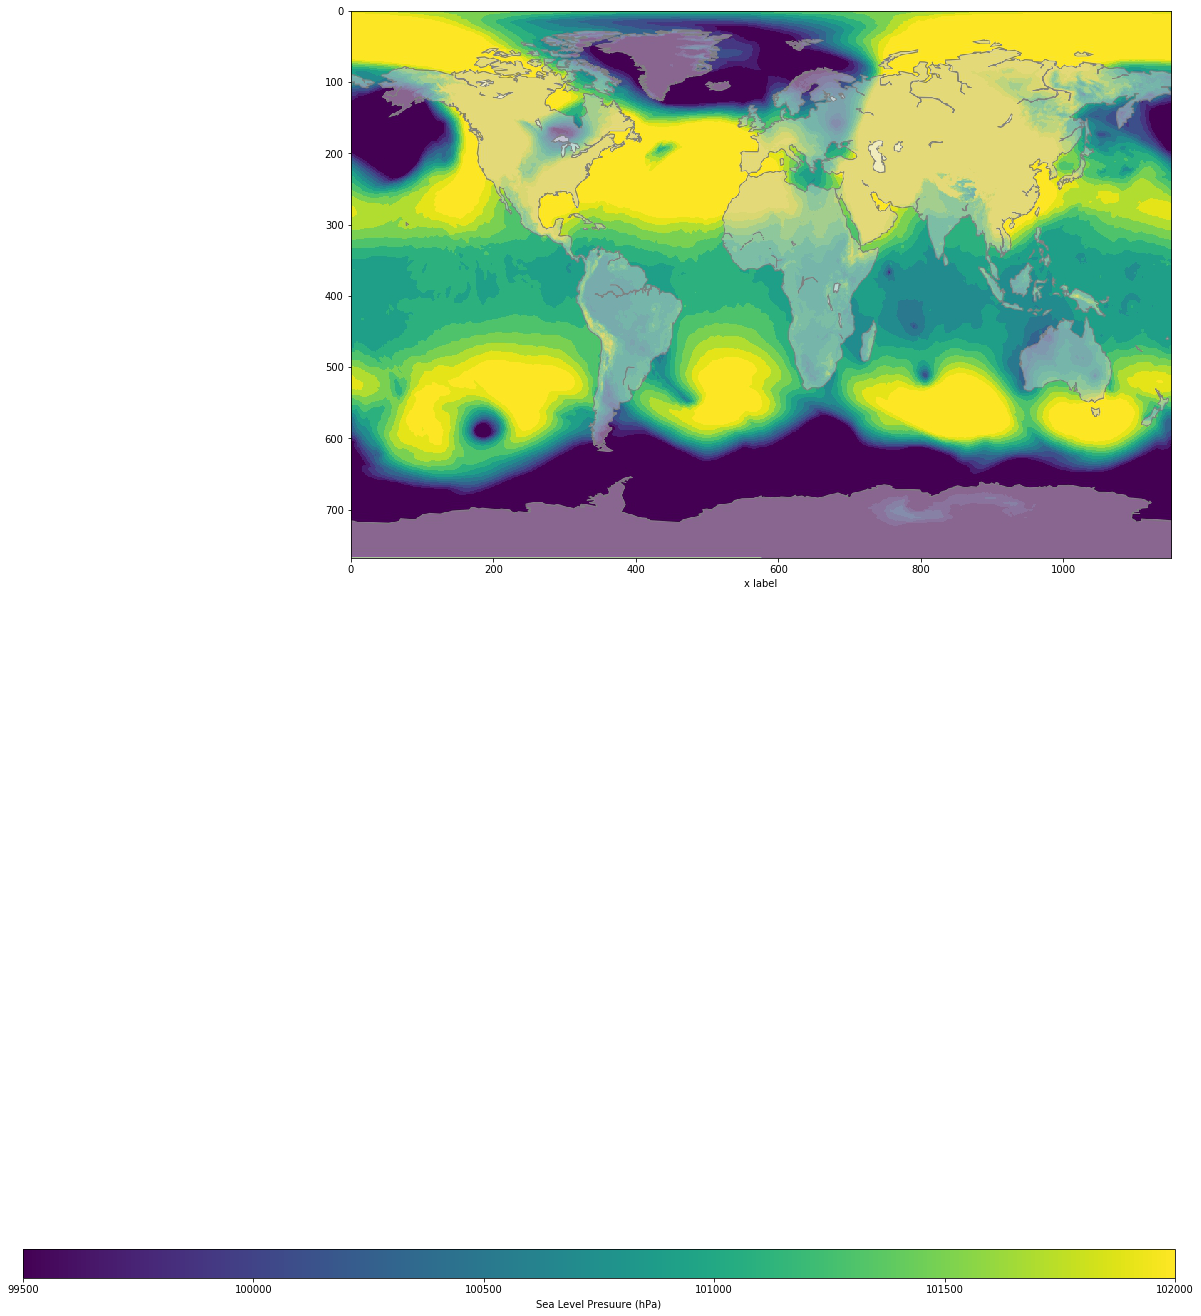

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np; np.random.seed(1)

fig, ax = plt.subplots(figsize=(20,20))
img=mpimg.imread('jpg_out/container_a/vor_psl_ivt/data-2000-01-01-01-1.jpg')

fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=99500, vmax=102000)
#bounds = np.linspace(99500, 102001, num = 5)
imgplot = plt.imshow(img)
ax.set_xlabel("x label")

cbaxes = fig.add_axes([0, 0, 0.8, 0.02])
cb1 = mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Sea Level Presuure (hPa)')
plt.show()